# Predicting Stroke using Machine Learning

## 1. Problem Definition

We are going to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status

Here is the dataset: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

A good inspiration to treat imbalance dataset: https://www.kaggle.com/code/pjarbas/pipeline-with-imbalanced-data-smote-histgboost

## 2. Features

1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not

### Import tools

In [1]:
# Regular EDA and plotting libraries
import numpy as np # np is short for numpy
import pandas as pd # pandas is so commonly used, it's shortened to pd
import matplotlib.pyplot as plt
import seaborn as sns # seaborn gets shortened to sns

# We want our plots to appear in the notebook
%matplotlib inline 

## Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

# Visualizing Pipelines in HTML
from sklearn import set_config; set_config(display='diagram')

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
# from sklearn.metrics import plot_roc_curve # note: this was changed in Scikit-Learn 1.2+ to be "RocCurveDisplay" (see below)
from sklearn.metrics import RocCurveDisplay # new in Scikit-Learn 1.2+

# Print last updated
import time
print(f"Last updated: {time.asctime()}")

Last updated: Thu Sep 14 10:53:35 2023


### Load data

In [2]:
df = pd.read_csv("../raw_data/healthcare-dataset-stroke-data.csv") # 'DataFrame' shortened to 'df'
df.shape # (rows, columns)

(5110, 12)

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
# Let's see how many positive (1) and negative (0) samples we have in our dataframe
df.stroke.value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

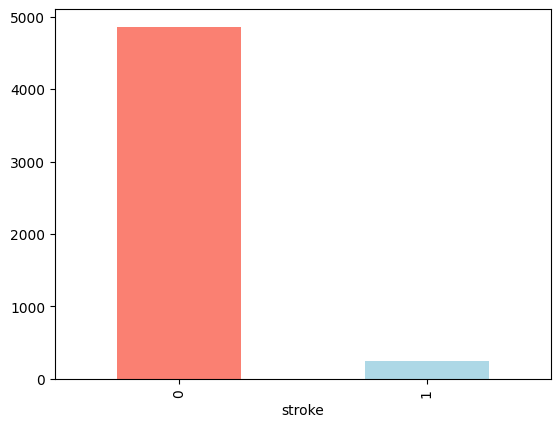

In [5]:
# Plot the value counts with a bar graph
df.stroke.value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

We can see that the values are not well balanced. We must do something.

**TODO: Balance the target**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [7]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Make ids as the indexs of the Dataframe

In [8]:
df.set_index('id', inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 3. Modeling

### Clean the data

#### Check there are no missing data

In [9]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

### Create X and y

In [10]:
# Everything except target variable
X = df.drop("stroke", axis=1)

# Target variable
y = df.stroke

In [11]:
X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked


In [12]:
y.head()

id
9046     1
51676    1
31112    1
60182    1
1665     1
Name: stroke, dtype: int64

### Split the data

In [13]:
# Random seed for reproducibility
np.random.seed(42)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X, # independent variables 
                                                    y, # dependent variable
                                                    test_size = 0.2) # percentage of data to use for test set

In [14]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4088 entries, 4970 to 28933
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4088 non-null   object 
 1   age                4088 non-null   float64
 2   hypertension       4088 non-null   int64  
 3   heart_disease      4088 non-null   int64  
 4   ever_married       4088 non-null   object 
 5   work_type          4088 non-null   object 
 6   Residence_type     4088 non-null   object 
 7   avg_glucose_level  4088 non-null   float64
 8   bmi                3932 non-null   float64
 9   smoking_status     4088 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 351.3+ KB


### Preprocess the data

In [15]:
X_train.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
dtype: object

In [16]:
def build_pipeline(with_model = True):
    # Impute then scale numerical values
    num_transformer = make_pipeline(SimpleImputer(strategy="mean"),StandardScaler())
    num_col = make_column_selector(dtype_include=['float64'])
    
    # Encode categorical values
    cat_transformer = OneHotEncoder(handle_unknown='ignore')
    cat_col = make_column_selector(dtype_include=['object','bool', 'int64']) # Add int64 in categorical values to include `heart_disease` and `hypertension`
    
    # Parallelize "num_transformer" and "cat_transfomer"
    preprocessor = make_column_transformer(
        (num_transformer, num_col),
        (cat_transformer, cat_col),
        remainder='passthrough'
    )
    
    smt = SMOTE(random_state=42)
    
    model = RandomForestClassifier()

    pipeline = make_pipeline(preprocessor, smt, model) if with_model else make_pipeline(preprocessor, smt)

    return pipeline

In [17]:
pipeline_with_no_model = build_pipeline(with_model=False)
pipeline_with_no_model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2a3df0c90>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2a3df0b50>)])),
                ('smote', SMOTE(random_state=42))])

### Check dataset is well balanced

In [18]:
X_resampled, y_resampled = pipeline_with_no_model.fit_resample(X_train, y_train)

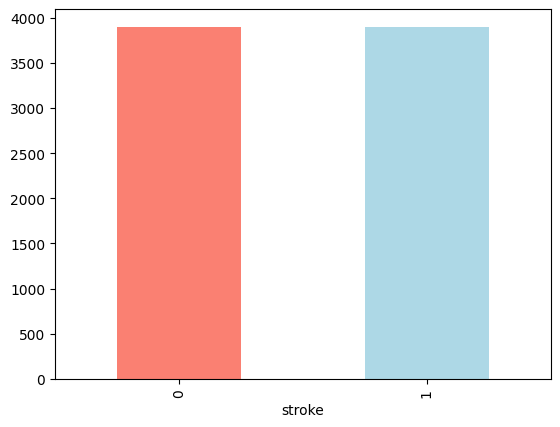

In [19]:
y_resampled.value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

In [20]:
# Full pipeline

pipeline_with_model = build_pipeline()

In [21]:
# Train the pipeline
pipeline_with_model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2a3de27d0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x2a3de2b90>)])),
                ('smote', SMOTE(random_state=42)),
                ('randomforestclassifier', RandomForestClassifier())])

In [22]:
# Score model
pipeline_with_model.score(X_test,y_test)

0.9275929549902152

## 4.Prediction

In [23]:
y_pred = pipeline_with_model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

## 5. Evaluation

Cross validation

In [24]:
np.random.seed(42)

cross_val_score(pipeline_with_model, X_train, y_train, cv=5, scoring='accuracy').mean()

0.9332180168964517

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       960
           1       0.30      0.15      0.20        62

    accuracy                           0.93      1022
   macro avg       0.62      0.56      0.58      1022
weighted avg       0.91      0.93      0.92      1022



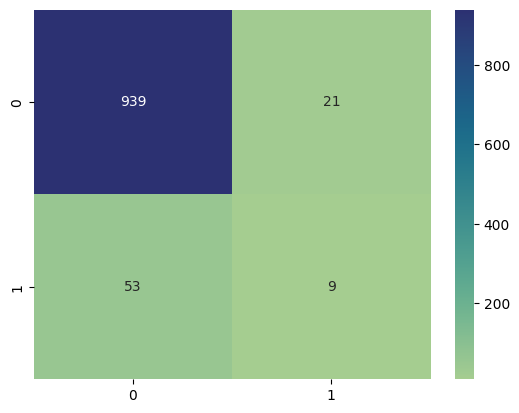

In [26]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, cmap='crest', fmt="");

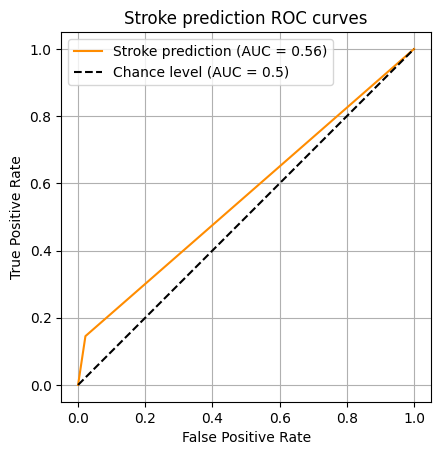

In [27]:
RocCurveDisplay.from_predictions(
    y_test,
    y_pred,
    name="Stroke prediction",
    color="darkorange",
    plot_chance_level=True,
)
plt.axis("square")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Stroke prediction ROC curves")
plt.legend();